In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Identify data & count the files inside each folder

In [18]:
import os


folder1_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/no"
folder2_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes"

# Count files in folder 1
folder1_files = [f for f in os.listdir(folder1_path) if os.path.isfile(os.path.join(folder1_path, f))]
count1 = len(folder1_files)

# Count files in folder 2
folder2_files = [f for f in os.listdir(folder2_path) if os.path.isfile(os.path.join(folder2_path, f))]
count2 = len(folder2_files)

print(f"no folder contains {count1} files.")
print(f"yes folder contains {count2} files.")

no folder contains 98 files.
yes folder contains 155 files.


# Data spliting to (train,val,test)

In [19]:
import os
import shutil
import random

# Source folders
folder1_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/no"
folder2_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes"


destination_base = "/kaggle/working/split_dataset"


train_ratio = 0.7
val_ratio = 0.15  
test_ratio = 0.15 

class_map = {
    "no": folder1_path,
    "yes": folder2_path
}

for label, src_path in class_map.items():

    files = [f for f in os.listdir(src_path) if os.path.isfile(os.path.join(src_path, f))]
    random.shuffle(files)

    # Compute split indices
    total = len(files)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)

    train_files = files[:train_end]
    val_files = files[train_end:val_end]
    test_files = files[val_end:]

   
    train_target = os.path.join(destination_base, "train", label)
    val_target = os.path.join(destination_base, "val", label)
    test_target = os.path.join(destination_base, "test", label)

    os.makedirs(train_target, exist_ok=True)
    os.makedirs(val_target, exist_ok=True)
    os.makedirs(test_target, exist_ok=True)

    
    for f in train_files:
        shutil.copy(os.path.join(src_path, f), os.path.join(train_target, f))

    
    for f in val_files:
        shutil.copy(os.path.join(src_path, f), os.path.join(val_target, f))

    
    for f in test_files:
        shutil.copy(os.path.join(src_path, f), os.path.join(test_target, f))

    print(f"{label.upper()} - Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")


NO - Train: 68, Val: 14, Test: 16
YES - Train: 108, Val: 23, Test: 24


# visualize data

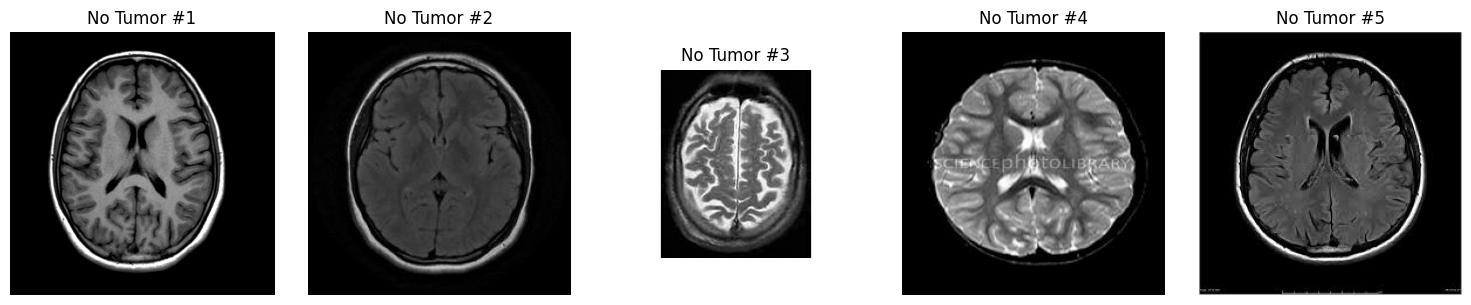

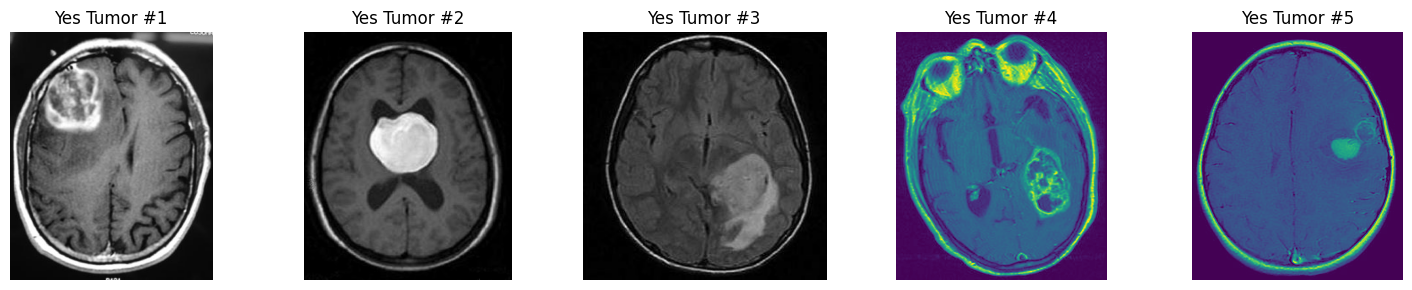

In [20]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def show_images_from_folder(folder_path, title, num_images=5):
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    files = files[:num_images]  

    plt.figure(figsize=(15, 3))
    for i, file in enumerate(files):
        img_path = os.path.join(folder_path, file)
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"{title} #{i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show 5 images from each folder
show_images_from_folder("/kaggle/working/split_dataset/train/no", "No Tumor")
show_images_from_folder("/kaggle/working/split_dataset/train/yes", "Yes Tumor")

# Check images size

In [21]:
import os
from PIL import Image

folder_path = "/kaggle/working/split_dataset/train/no"

for file in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file)
    if os.path.isfile(file_path):
        try:
            with Image.open(file_path) as img:
                print(f"{file}: {img.size}")  # (width, height)
        except Exception as e:
            print(f"Could not open {file}: {e}")

no 98.jpg: (728, 725)
no 5.jpeg: (224, 224)
No16.jpg: (300, 200)
46 no.jpg: (224, 224)
5 no.jpg: (225, 225)
20 no.jpg: (194, 259)
35 no.jpg: (224, 224)
29 no.jpg: (215, 234)
N21.jpg: (1024, 1024)
No19.jpg: (224, 224)
7 no.jpg: (428, 417)
N22.JPG: (276, 326)
No15.jpg: (393, 400)
no 94.jpg: (630, 630)
10 no.jpg: (173, 201)
17 no.jpg: (218, 231)
N16.jpg: (224, 224)
3 no.jpg: (225, 225)
no 3.jpg: (225, 225)
No22.jpg: (359, 449)
N11.jpg: (630, 614)
N1.JPG: (276, 338)
47 no.jpg: (225, 225)
19 no.jpg: (224, 224)
N2.JPG: (208, 248)
50 no.jpg: (224, 224)
34 no.jpg: (150, 198)
N26.JPG: (210, 264)
No14.jpg: (339, 340)
No20.jpg: (224, 224)
No17.jpg: (393, 400)
No18.jpg: (442, 454)
11 no.jpg: (300, 168)
9 no.jpg: (224, 224)
40 no.jpg: (225, 225)
no 8.jpg: (642, 361)
N20.JPG: (227, 262)
no 6.jpg: (214, 236)
45 no.jpg: (356, 474)
N5.jpg: (201, 250)
no 9.png: (1920, 1080)
No11.jpg: (630, 630)
15 no.jpg: (224, 224)
no 96.jpg: (550, 664)
4 no.jpg: (201, 250)
No13.jpg: (442, 442)
no 2.jpg: (232, 217)
No2

# We need to resize images they not equal at size

In [22]:
from PIL import Image
import os

# List of folders to resize
folders = [
    "/kaggle/working/split_dataset/train/no",
    "/kaggle/working/split_dataset/train/yes",
    "/kaggle/working/split_dataset/test/no",
    "/kaggle/working/split_dataset/test/yes"
]

target_size = (224, 224)

for folder_path in folders:
    print(f"Resizing images in: {folder_path}")
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        if os.path.isfile(file_path):
            try:
                with Image.open(file_path) as img:
                    img = img.convert("RGB")  # Ensure it can be saved as JPEG
                    img = img.resize(target_size, Image.Resampling.LANCZOS)
                    img.save(file_path)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

Resizing images in: /kaggle/working/split_dataset/train/no
Resizing images in: /kaggle/working/split_dataset/train/yes
Resizing images in: /kaggle/working/split_dataset/test/no
Resizing images in: /kaggle/working/split_dataset/test/yes


# Show images after resize

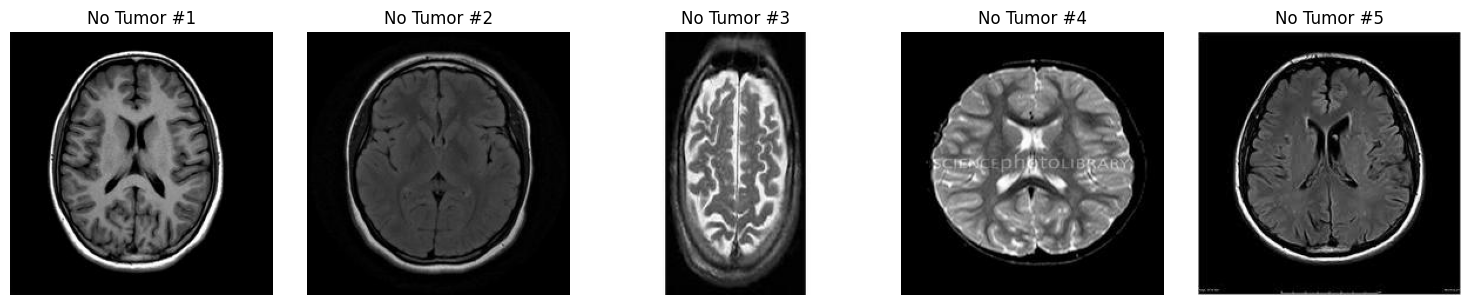

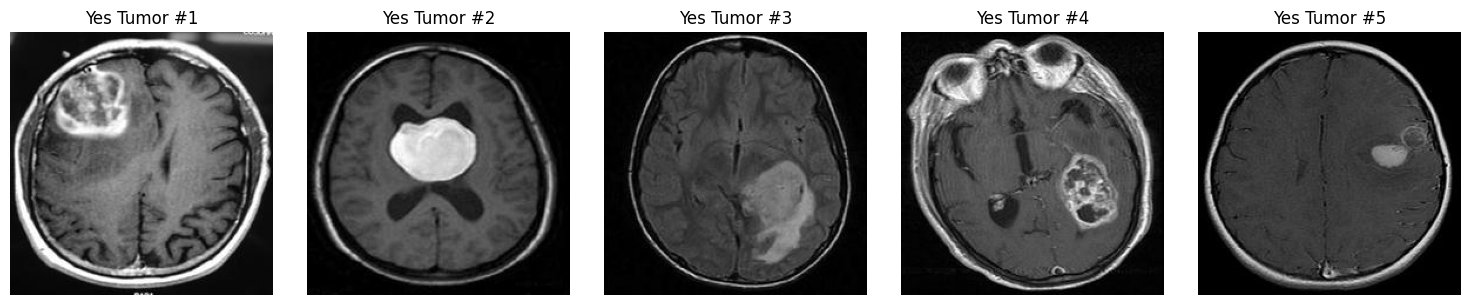

In [23]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def show_images_from_folder(folder_path, title, num_images=5):
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    files = files[:num_images]  

    plt.figure(figsize=(15, 3))
    for i, file in enumerate(files):
        img_path = os.path.join(folder_path, file)
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"{title} #{i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show 5 images from each folder
show_images_from_folder("/kaggle/working/split_dataset/train/no", "No Tumor")
show_images_from_folder("/kaggle/working/split_dataset/train/yes", "Yes Tumor")

# Check data resizing

In [24]:
import os
from PIL import Image

folder_path = "/kaggle/working/split_dataset/train/no"

for file in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file)
    if os.path.isfile(file_path):
        try:
            with Image.open(file_path) as img:
                print(f"{file}: {img.size}")  # (width, height)
        except Exception as e:
            print(f"Could not open {file}: {e}")

no 98.jpg: (224, 224)
no 5.jpeg: (224, 224)
No16.jpg: (224, 224)
46 no.jpg: (224, 224)
5 no.jpg: (224, 224)
20 no.jpg: (224, 224)
35 no.jpg: (224, 224)
29 no.jpg: (224, 224)
N21.jpg: (224, 224)
No19.jpg: (224, 224)
7 no.jpg: (224, 224)
N22.JPG: (224, 224)
No15.jpg: (224, 224)
no 94.jpg: (224, 224)
10 no.jpg: (224, 224)
17 no.jpg: (224, 224)
N16.jpg: (224, 224)
3 no.jpg: (224, 224)
no 3.jpg: (224, 224)
No22.jpg: (224, 224)
N11.jpg: (224, 224)
N1.JPG: (224, 224)
47 no.jpg: (224, 224)
19 no.jpg: (224, 224)
N2.JPG: (224, 224)
50 no.jpg: (224, 224)
34 no.jpg: (224, 224)
N26.JPG: (224, 224)
No14.jpg: (224, 224)
No20.jpg: (224, 224)
No17.jpg: (224, 224)
No18.jpg: (224, 224)
11 no.jpg: (224, 224)
9 no.jpg: (224, 224)
40 no.jpg: (224, 224)
no 8.jpg: (224, 224)
N20.JPG: (224, 224)
no 6.jpg: (224, 224)
45 no.jpg: (224, 224)
N5.jpg: (224, 224)
no 9.png: (224, 224)
No11.jpg: (224, 224)
15 no.jpg: (224, 224)
no 96.jpg: (224, 224)
4 no.jpg: (224, 224)
No13.jpg: (224, 224)
no 2.jpg: (224, 224)
No21.jp

# Load data

In [25]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.data import AUTOTUNE

# Directories
train_dir = "/kaggle/working/split_dataset/train"
val_dir   = "/kaggle/working/split_dataset/val"
test_dir  = "/kaggle/working/split_dataset/test"

# Parameters
img_size = (224, 224)
batch_size = 32

# Load training dataset
train_ds = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',  # one-hot encoded labels
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True
)

# Load validation dataset
val_ds = image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True
)

# Load test dataset
test_ds = image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=False
)

class_names = train_ds.class_names

# Optimize pipeline performance with prefetching
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 229 files belonging to 2 classes.
Found 69 files belonging to 2 classes.
Found 70 files belonging to 2 classes.


In [26]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Prepare Algo

In [27]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential as KerasSequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.regularizers import l2

# Load MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3))

# Freeze base model layers
base_model.trainable = False

# Data augmentation layer
data_augmentation = KerasSequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
])

# Build the final model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Set hyperprameters

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=2e-3),  # smaller LR
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-7)
]

# Start trainning

In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("best_model.h5",  # File name
                             monitor="val_loss",  # or "val_accuracy"
                             save_best_only=True,
                             save_weights_only=False,
                             mode="min",  # or "max" for accuracy
                             verbose=1)


history=model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks)

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9320 - loss: 0.1604 - val_accuracy: 0.9710 - val_loss: 0.1303 - learning_rate: 1.2500e-04
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9555 - loss: 0.1599 - val_accuracy: 0.9710 - val_loss: 0.1313 - learning_rate: 1.2500e-04
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9202 - loss: 0.1706 - val_accuracy: 0.9710 - val_loss: 0.1311 - learning_rate: 1.2500e-04
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9465 - loss: 0.1552 - val_accuracy: 0.9710 - val_loss: 0.1317 - learning_rate: 1.2500e-04
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9316 - loss: 0.1802 - val_accuracy: 0.9710 - val_loss: 0.1329 - learning_rate: 6.2500e-05
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9328 - loss: 0.1638 - val_accuracy: 0.9710 - val_loss: 0.1337 - learning_rate: 6.2500e-05


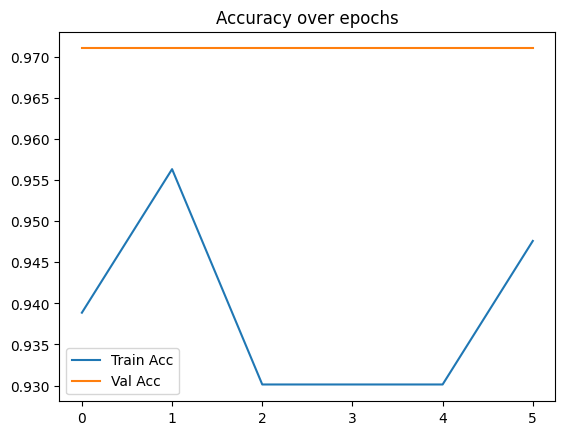

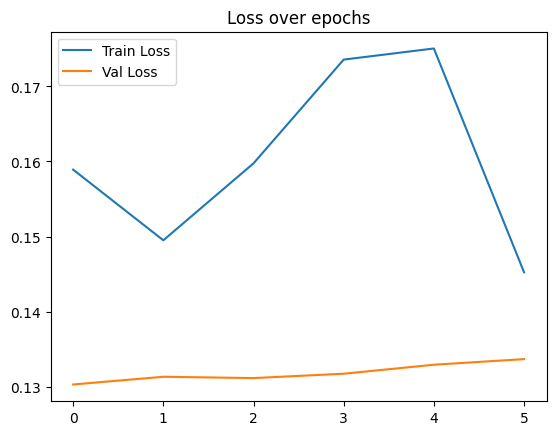

In [38]:
import matplotlib.pyplot as plt

# Assuming you saved these during training
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over epochs')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

In [42]:
model.save("my_model.h5")

# Test model Accuracy

In [40]:
# Evaluate the model on test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9623 - loss: 0.1698 
Test Accuracy: 97.14%
Test Loss: 0.1561


In [ ]:
print(class_names)

In [43]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os

In [44]:
img_path = "/kaggle/working/split_dataset/test/yes/Y13.jpg"
img = image.load_img(img_path, target_size=(224, 224))  # same size as training
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize if you did that during training
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]
confidence = np.max(predictions) * 100

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [45]:
print(f"Predicted class: {class_names[predicted_class]} ({confidence:.2f}% confidence)")

Predicted class: yes (100.00% confidence)


# Test model

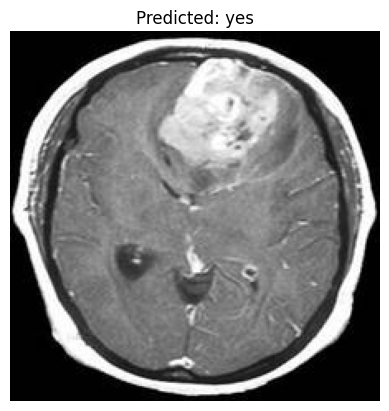

In [46]:
plt.imshow(img)
plt.title(f"Predicted: {class_names[predicted_class]}")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


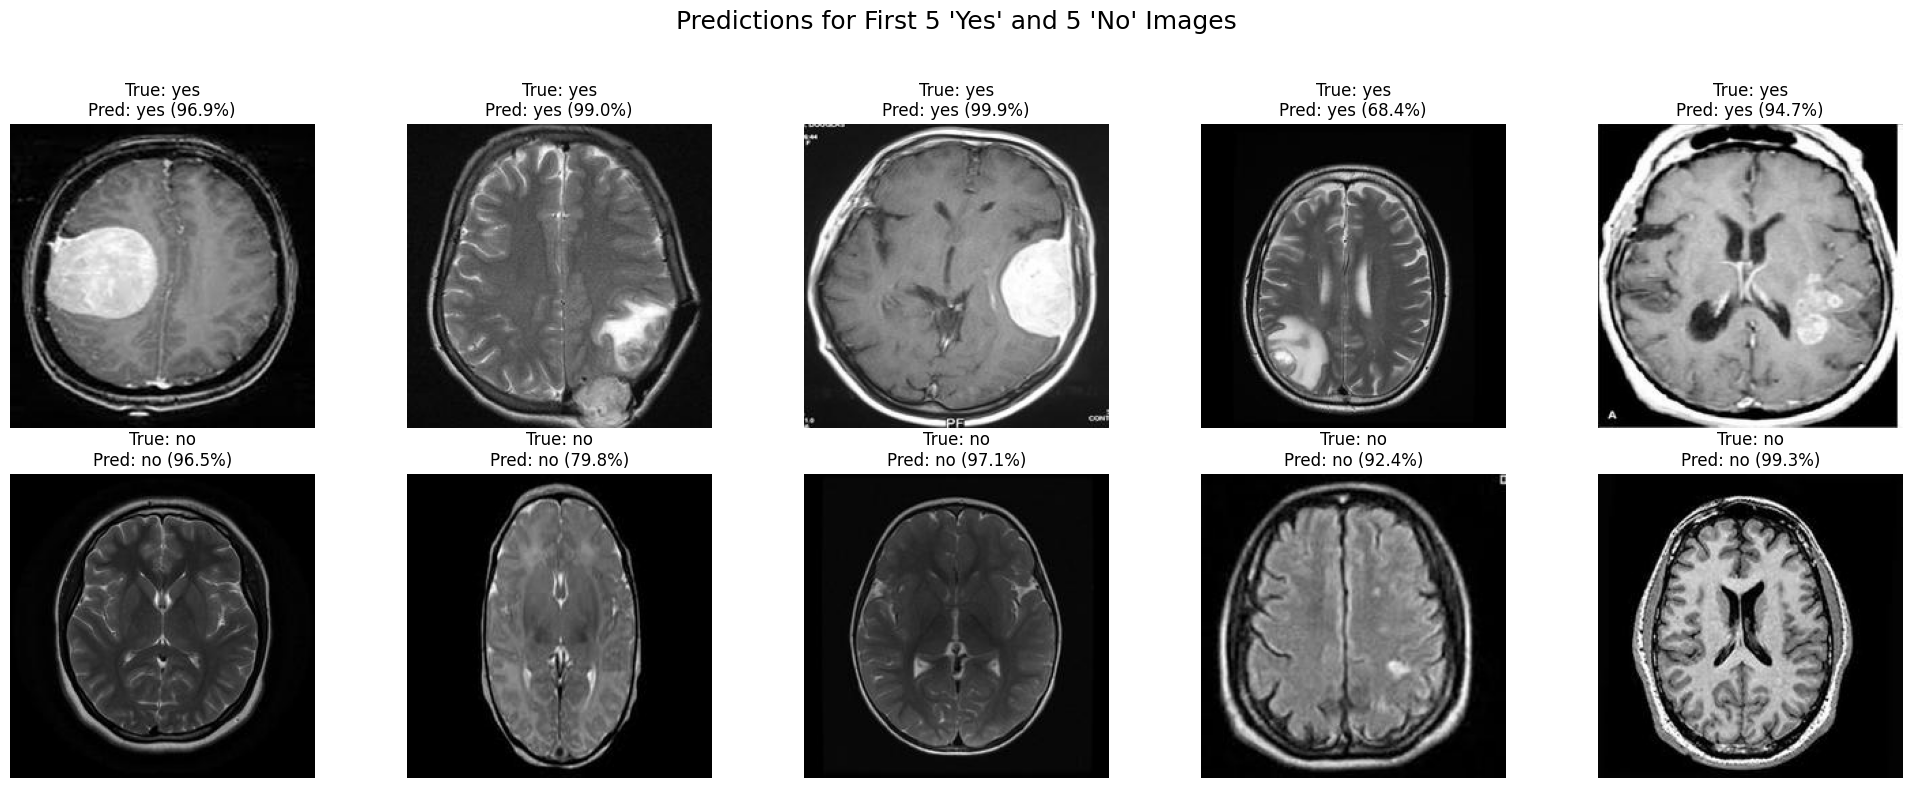

In [47]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image


yes_dir = "/kaggle/working/split_dataset/test/yes"
no_dir = "/kaggle/working/split_dataset/test/no"

yes_images = sorted(os.listdir(yes_dir))[:5]
no_images = sorted(os.listdir(no_dir))[:5]


image_info = [(os.path.join(yes_dir, img), 'yes') for img in yes_images] + \
             [(os.path.join(no_dir, img), 'no') for img in no_images]


fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Predictions for First 5 'Yes' and 5 'No' Images", fontsize=18)

class_names = ['no', 'yes']

for ax, (img_path, true_label) in zip(axes.flat, image_info):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction) * 100


    ax.imshow(img)
    ax.set_title(f"True: {true_label}\nPred: {class_names[predicted_class]} ({confidence:.1f}%)")
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
plt.show()


In [1]:
# Save the model using the newer format (recommended)
model.save("class.keras", save_format="keras")


NameError: name 'model' is not defined